In [8]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available at [NeuroVault (2238)](http://neurovault.org/collections/2238/).


In [9]:
import os
from subprocess import check_call
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection ZJNRUHIM and UMMSIQGP
 - Download and save the packs in sub-folder `input/data` 

In [10]:
nv_collections = (
    '2238',
)

studies = (
    'ds109',
)

for nv_collection in nv_collections:
    request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
    response = urlopen(request)
    elevations = response.read()
    data = json.loads(elevations)

    pwd = os.path.dirname(os.path.realpath('__file__'))
    input_dir = os.path.join(pwd, "input")
    data_dir = os.path.join(input_dir, "data")

    if not os.path.isdir(data_dir):
        if not os.path.isdir(input_dir):
            os.makedirs(input_dir)
        os.makedirs(data_dir)

    for nidm_result in data["results"]:
        url = nidm_result["zip_file"]
        study_name = nidm_result["name"]

        localzip = os.path.join(data_dir, study_name + ".zip")
        localzip_rel = localzip.replace(pwd, '.')
        if not os.path.isfile(localzip):
            # Copy .nidm.zip export locally in a the data directory
            try:
                f = urlopen(url)
                print("downloading " + url + " at " + localzip_rel)
                with open(localzip, "wb") as local_file:
                    local_file.write(f.read())
            except HTTPError, e:
                raise Exception(["HTTP Error:" + e.code + url])
            except URLError, e:
                raise Exception(["URL Error:" + e.reason + url])
        else:
            print(url + " already downloaded at " + localzip_rel)
            
    for afni_image, local_name in (
            ('Negative_clustered_t_stat.nii.gz', 'afni_exc_set_neg.nii.gz'), 
            ('Positive_clustered_t_stat.nii.gz', 'afni_exc_set_pos.nii.gz'),
            ('3dMEMA_result_t_stat_masked.nii.gz', 'afni_stat.nii.gz'),
            ('mask.nii.gz', 'afni_mask.nii.gz')):

        url = "http://neurovault.org/media/images/" + nv_collection + '/' + afni_image
        local_file = os.path.join(data_dir, local_name)
        if not os.path.isfile(local_file):
            # Copy file locally in a the data directory
            try:
                f = urlopen(url)
                print("downloading " + url + " at " + local_file)
                with open(local_file, "wb") as local_fid:
                    local_fid.write(f.read())
            except HTTPError, e:
                raise Exception(["HTTP Error:" + str(e.code) + url])
            except URLError, e:
                raise Exception(["URL Error:" + e.reason + url])
        else:
            print(url + " already downloaded at " + local_file)
     
    for study in studies:
        for euler_char_file, local_name in (
                ('AFNI/LEVEL2/euler_chars.csv', 'afni_euler_chars.csv'),
                ('FSL/LEVEL2/group.gfeat/cope1.feat/stats/euler_chars.csv', 'fsl_euler_chars.csv'),
                ('SPM/LEVEL2/euler_chars.csv', 'spm_euler_chars.csv')):
        
            url = "https://raw.githubusercontent.com/AlexBowring/Software_Comparison/comparisons/" + study + "/" + euler_char_file
            local_file = os.path.join(data_dir, local_name)
            if not os.path.isfile(local_file):
                # Copy file locally in a the data directory
                try:
                    f = urlopen(url)
                    print("downloading " + url + " at " + local_file)
                    with open(local_file, "wb") as local_fid:
                        local_fid.write(f.read())
                except HTTPError, e:
                    raise Exception(["HTTP Error:" + str(e.code) + url])
                except URLError, e:
                    raise Exception(["URL Error:" + e.reason + url])
            else:
                print(url + " already downloaded at " + local_file)


downloading http://neurovault.org/collections/2238/group.gfeat.nidm.zip at ./input/data/group.gfeat.nidm.zip
downloading http://neurovault.org/collections/2238/spm_0001.nidm.zip at ./input/data/spm_0001.nidm.zip
downloading http://neurovault.org/collections/2238/spm_0002.nidm.zip at ./input/data/spm_0002.nidm.zip
downloading http://neurovault.org/media/images/2238/Negative_clustered_t_stat.nii.gz at /Users/maullz/Desktop/Software_Comparison/input/data/afni_exc_set_neg.nii.gz
downloading http://neurovault.org/media/images/2238/Positive_clustered_t_stat.nii.gz at /Users/maullz/Desktop/Software_Comparison/input/data/afni_exc_set_pos.nii.gz
downloading http://neurovault.org/media/images/2238/3dMEMA_result_t_stat_masked.nii.gz at /Users/maullz/Desktop/Software_Comparison/input/data/afni_stat.nii.gz
downloading http://neurovault.org/media/images/2238/mask.nii.gz at /Users/maullz/Desktop/Software_Comparison/input/data/afni_mask.nii.gz
downloading https://raw.githubusercontent.com/AlexBowring/

In [11]:
import zipfile
import shutil

# *** SPM group activations
spm_pack = open('./input/data/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/data/')
z.extract('Mask.nii.gz', './input/data/')
z.extract('TStatistic.nii.gz', './input/data/')

# Thresholded statistics
spm_exc_set_file = './input/data/spm_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet.nii.gz', spm_exc_set_file)

# Unthresholded statistics
spm_stat_file = './input/data/spm_stat.nii.gz'
shutil.move('./input/data/TStatistic.nii.gz', spm_stat_file)

# Analysis mask
spm_mask_file = './input/data/spm_mask.nii.gz'
shutil.move('./input/data/Mask.nii.gz', spm_mask_file)

# *** SPM group deactivations
spm_deact_pack = open('./input/data/spm_0002.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_deact_pack)
z.extract('ExcursionSet.nii.gz', './input/data/')

# Thresholded statistics
spm_exc_set_file_neg = './input/data/spm_exc_set_neg.nii.gz'
shutil.move('./input/data/ExcursionSet.nii.gz', spm_exc_set_file_neg)

# *** FSL group activations and deactivations
fsl_pack = open('./input/data/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/data/')
z.extract('ExcursionSet_T002.nii.gz', './input/data/')
z.extract('Mask.nii.gz', './input/data/')
z.extract('TStatistic_T001.nii.gz', './input/data/')

# Thresholded statistics
fsl_exc_set_file = './input/data/fsl_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet_T001.nii.gz', fsl_exc_set_file)
fsl_exc_set_file_neg = './input/data/fsl_exc_set_neg.nii.gz'
shutil.move('./input/data/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

# Unthresholded statistics
fsl_stat_file = './input/data/fsl_stat.nii.gz'
shutil.move('./input/data/TStatistic_T001.nii.gz', fsl_stat_file)

# Analysis mask
fsl_mask_file = './input/data/fsl_mask.nii.gz'
shutil.move('./input/data/Mask.nii.gz', fsl_mask_file)

exc_sets = dict()
exc_sets["spm"] = (spm_mask_file, (spm_exc_set_file, spm_exc_set_file_neg), spm_stat_file)
exc_sets["fsl"] = (fsl_mask_file, (fsl_exc_set_file, fsl_exc_set_file_neg), fsl_stat_file)
afni_mask_file = './input/data/afni_mask.nii.gz'
afni_exc_set_file = './input/data/afni_exc_set_pos.nii.gz'
afni_exc_set_file_neg = './input/data/afni_exc_set_neg.nii.gz'
afni_stat_file = './input/data/afni_stat.nii.gz'
exc_sets["afni"] = (afni_mask_file, (afni_exc_set_file, afni_exc_set_file_neg), afni_stat_file)

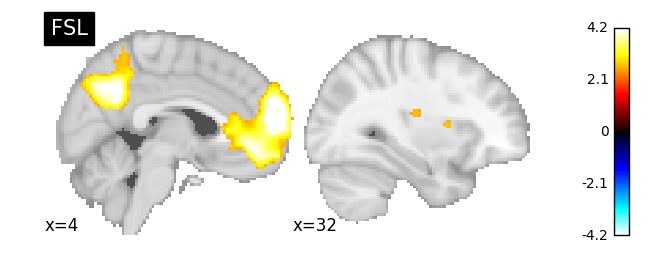

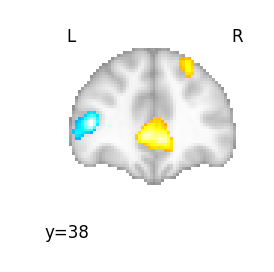

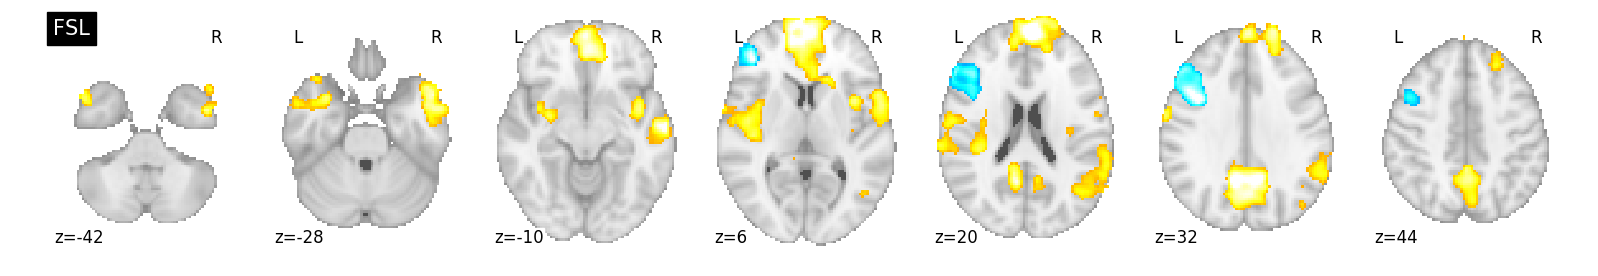

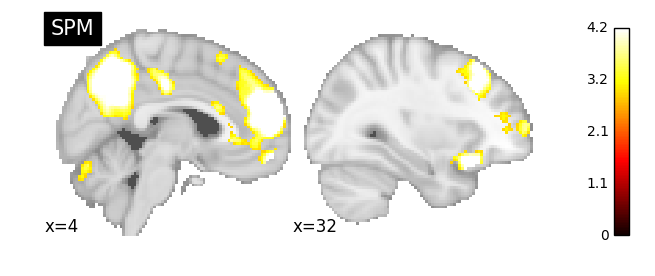

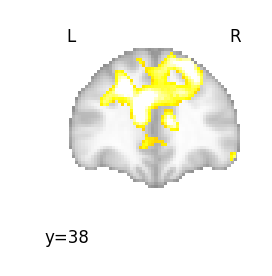

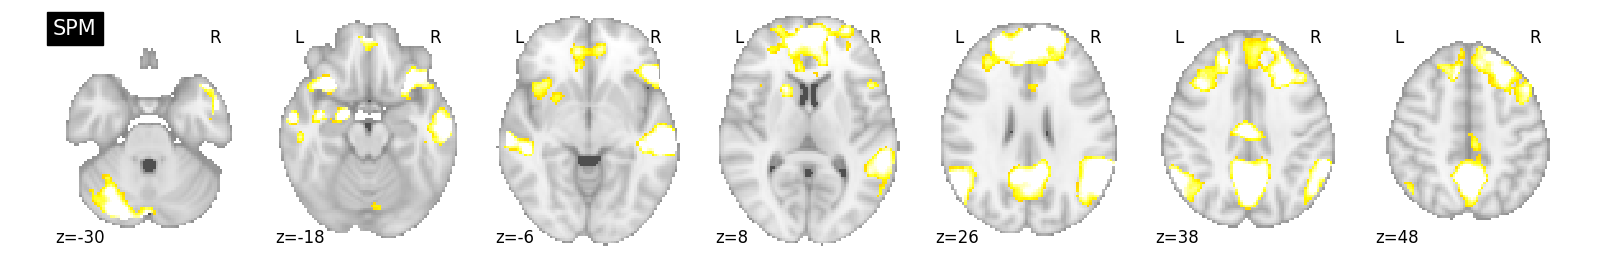

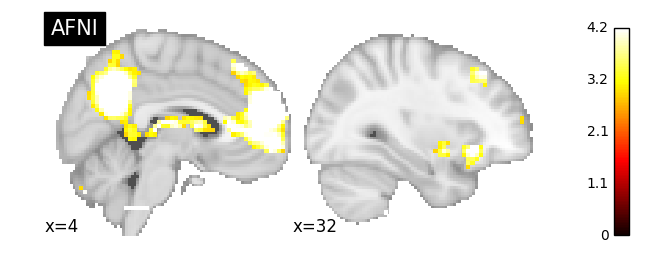

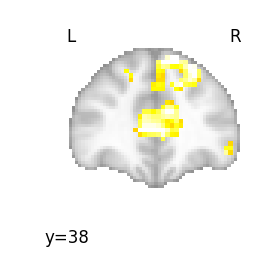

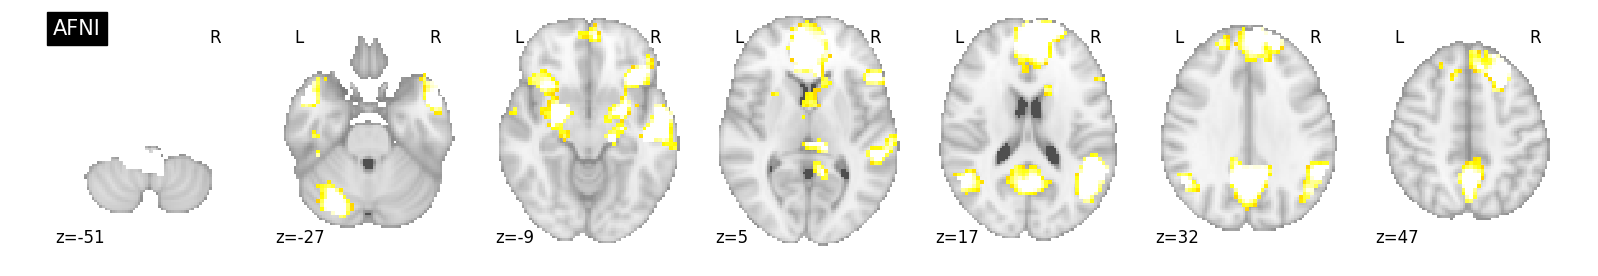

In [12]:
from nilearn import plotting
from nilearn.image import math_img
import numpy as np
from nilearn.masking import apply_mask
from nilearn.image import load_img, new_img_like
from nilearn._utils.niimg_conversions import _safe_get_data
import nibabel as nib

for soft, (mask_file, (exc_set_file, exc_set_file_neg), stat_file) in exc_sets.items():
    # Remove NaNs
    n = nib.load(exc_set_file)
    d = n.get_data()
    exc_set_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    n = nib.load(exc_set_file_neg)
    d = n.get_data()
    exc_set_neg_nonan = nib.Nifti1Image(np.nan_to_num(d), n.affine, header=n.header)
    
    # Combine activations and deactivations in a single image 
    to_display = math_img("img1-img2", img1=exc_set_nonan, img2=exc_set_neg_nonan)

    # Display x=4, y=32 and y=38 as in the manuscript
    display = plotting.plot_stat_map(to_display, display_mode='x', cut_coords=[4, 32], draw_cross=False, colorbar=True, 
                           title=soft.upper(), threshold=0.000001, vmax=4.2)
    display = plotting.plot_stat_map(to_display, cut_coords=[38], draw_cross=False, display_mode='y', 
                           threshold=0.000001, colorbar=False, vmax=4.2)
    # Additional plot: slices along z
    display = plotting.plot_stat_map(to_display, cut_coords=7, draw_cross=False, display_mode='z', 
                           threshold=0.000001, colorbar=False, vmax=4.2, title=soft.upper())
#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask')

#     # Analysis mask
#     display = plotting.plot_roi(mask_file, title=soft.upper()+': Analysis mask', 
#                                 cut_coords=7, draw_cross=False, display_mode='z')


plotting.show()

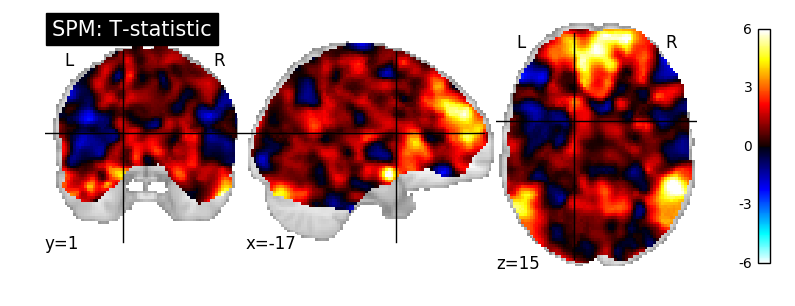

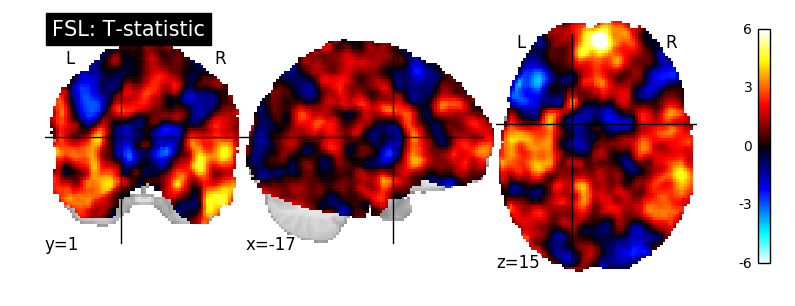

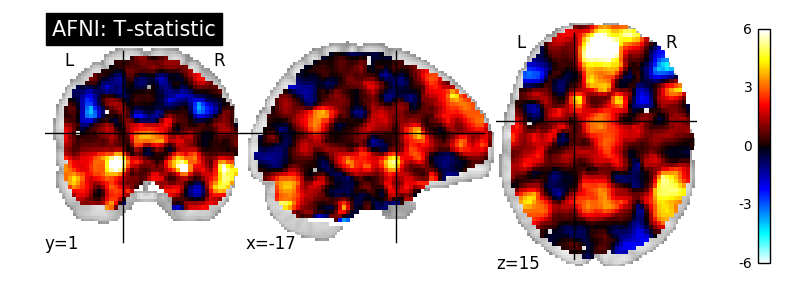

In [13]:
from nilearn import plotting
plotting.plot_stat_map(spm_stat_file, vmax=6, title="SPM: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(fsl_stat_file, vmax=6, title="FSL: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])
plotting.plot_stat_map(afni_stat_file, vmax=6, title="AFNI: T-statistic", display_mode='ortho', cut_coords=[-17, 1, 15])

In [14]:
import pandas as pd

afni_euler_chars = pd.read_csv('./input/data/afni_euler_chars.csv', header=None, names=['Threshold','AFNI EC'])
fsl_euler_chars = pd.read_csv('./input/data/fsl_euler_chars.csv', usecols=[1], header=None, names=['FSL EC'])
spm_euler_chars = pd.read_csv('./input/data/spm_euler_chars.csv', usecols=[1], header=None, names=['SPM EC'])
euler_chars = pd.concat([afni_euler_chars, fsl_euler_chars, spm_euler_chars], axis=1)

euler_chars

,Threshold,AFNI EC,FSL EC,SPM EC
0,-6.0,5,2,1
1,-5.9,5,2,1
2,-5.8,5,2,1
3,-5.7,5,2,1
4,-5.6,5,2,1
5,-5.5,5,4,1
6,-5.4,5,4,1
7,-5.3,5,4,1
8,-5.2,5,4,1
9,-5.1,5,6,1
